In [1]:
import numpy as np
from constants import DATA_DIR

from astrofit.utils import (
    AsteroidLoader,
    LightcurveBinner,
    LightcurvePlotter,
    LightcurveSplitter,
)
from astrofit.utils.enums import BinningMethod

In [2]:
asteroid_loader = AsteroidLoader(DATA_DIR)
lightcurve_binner = LightcurveBinner()
lightcurve_plotter = LightcurvePlotter()
lightcurve_splitter = LightcurveSplitter()

In [3]:
asteroids = sorted((
    asteroid_loader.load_asteroid(name) for name in asteroid_loader.available_asteroids
), key=lambda asteroid: asteroid.period)
asteroids

[Asteroid(id=22, name=Kalliope, period=4.1482015, lightcurves=155),
 Asteroid(id=16, name=Psyche, period=4.195948, lightcurves=209),
 Asteroid(id=55, name=Pandora, period=4.804043, lightcurves=36),
 Asteroid(id=9, name=Metis, period=5.079177, lightcurves=38),
 Asteroid(id=39, name=Laetitia, period=5.138238, lightcurves=68),
 Asteroid(id=87, name=Sylvia, period=5.183641, lightcurves=41),
 Asteroid(id=433, name=Eros, period=5.27025528, lightcurves=118),
 Asteroid(id=4, name=Vesta, period=5.342124, lightcurves=169),
 Asteroid(id=29, name=Amphitrite, period=5.39012, lightcurves=66),
 Asteroid(id=31, name=Euphrosyne, period=5.529594, lightcurves=64),
 Asteroid(id=52, name=Europa, period=5.629959, lightcurves=49),
 Asteroid(id=69, name=Hesperia, period=5.65534, lightcurves=38),
 Asteroid(id=45, name=Eugenia, period=5.699152, lightcurves=101),
 Asteroid(id=43, name=Ariadne, period=5.761987, lightcurves=43),
 Asteroid(id=79, name=Eurynome, period=5.977722, lightcurves=39),
 Asteroid(id=93, nam

In [4]:
np.percentile([asteroid.period for asteroid in asteroids], [5, 25, 50, 75, 95])

array([ 5.15866935,  6.911748  ,  9.1461865 , 13.6840525 , 22.434295  ])

In [5]:
asteroid = asteroids[-4]

In [6]:
# Splits long lightcurve into smaller ones based on a time difference between consecutive points
# and a minimum number of points in a lightcurve
#
# Maximum time difference between consecutive points is set right now to 1 hour apart
splitted = lightcurve_splitter.split_lightcurves(
    asteroid.lightcurves,
    max_hours_diff=1,
    min_no_points=5,
)
splitted

[Lightcurve(id=11185, period=0.96598h points_count=5, first_JD=2454259.7938, last_JD=2454259.834049),
 Lightcurve(id=11185, period=0.93168h points_count=5, first_JD=2454716.769891, last_JD=2454716.808711),
 Lightcurve(id=11185, period=0.53522h points_count=5, first_JD=2455162.967787, last_JD=2455162.990088)]

In [7]:
bins = lightcurve_binner.bin_lightcurves(
    splitted,
    max_time_diff=30,
    binning_method=BinningMethod.LAST_TO_FIRST_DIFF,
)
bins

[[Lightcurve(id=11185, period=0.96598h points_count=5, first_JD=2454259.7938, last_JD=2454259.834049)],
 [Lightcurve(id=11185, period=0.93168h points_count=5, first_JD=2454716.769891, last_JD=2454716.808711)],
 [Lightcurve(id=11185, period=0.53522h points_count=5, first_JD=2455162.967787, last_JD=2455162.990088)]]

In [8]:
prev_lc = None
for _bin in bins:
    curr_lc = _bin[-1]
    if prev_lc is None:
        prev_lc = curr_lc
        continue

    print(f"Difference: {curr_lc.first_JD - prev_lc.last_JD:.4f}")
    prev_lc = curr_lc


Difference: 456.9358
Difference: 446.1591


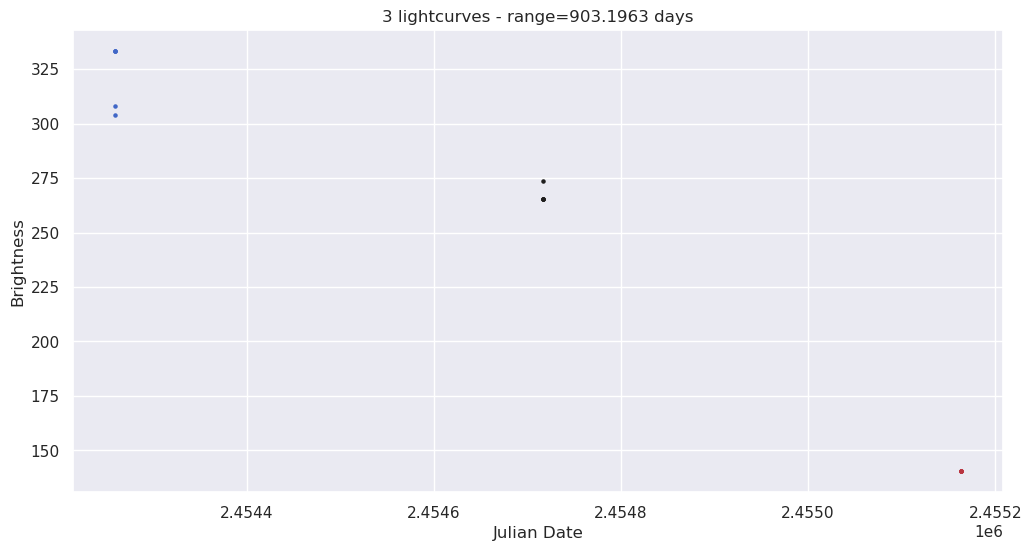

In [9]:
lightcurve_plotter.plot_lightcurves(splitted, split_plots=False)

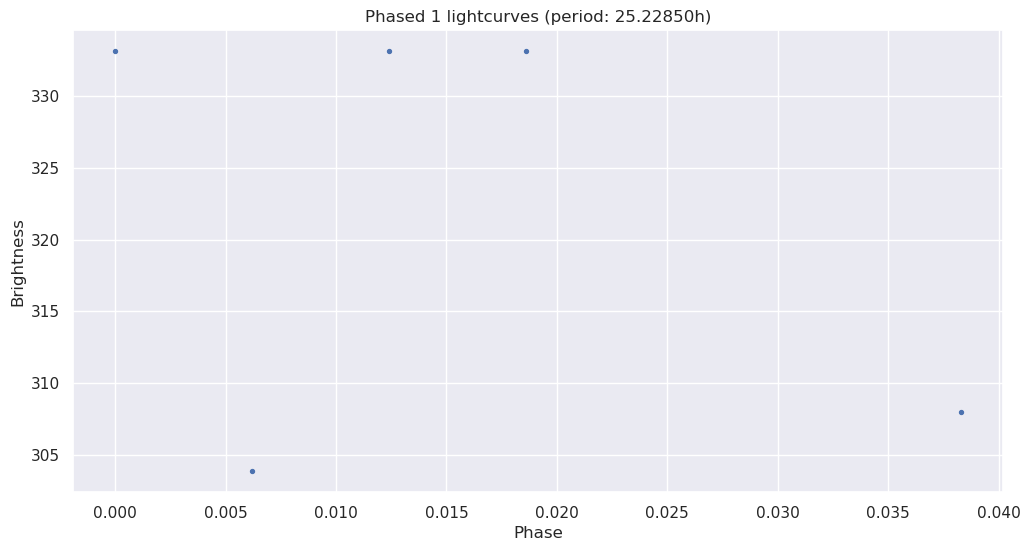

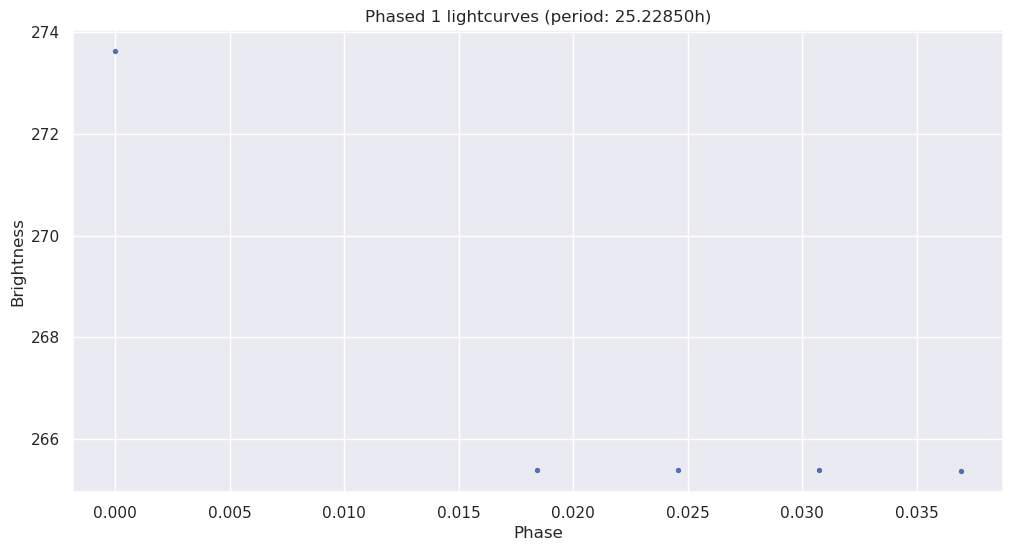

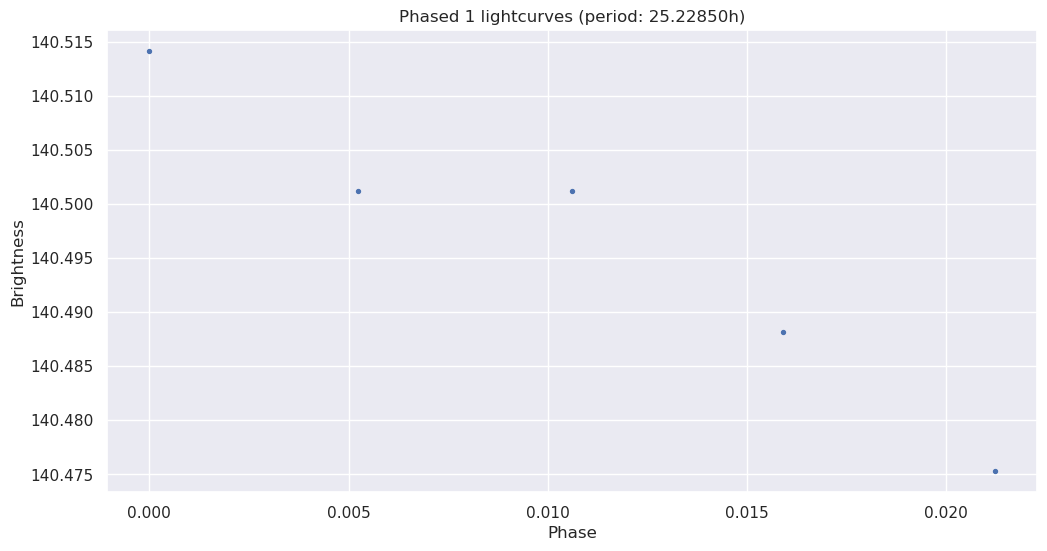

In [10]:
for _bin in bins:
    lightcurve_plotter.plot_phased_lightcurves(_bin, period=asteroid.period)